In [43]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [5]:
df = pd.read_csv(csv_path)

In [8]:
df = df[5::6].copy()

In [10]:
date_time = pd.to_datetime(df.pop("Date Time"), format='%d.%m.%Y %H:%M:%S')

In [13]:
df.describe().T

count         mean        std      min      25%      50%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.20   989.57   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.35     9.41   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.44   283.46   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.24     5.21   
rh (%)           70091.0    76.009788  16.474920    13.88    65.21    79.30   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.77    11.82   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.22     8.86   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.87     2.19   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.92     5.59   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.29     8.96   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.47  1213.80   
wv (m/s)         70091.0     1.702567  65.447512 -9999.00     0.99     1.76   
max. wv (m/s)    70091.0     2.963041  75.597657 -9999.00     1.76     2.98   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.30   198.10   

                      75%      max  
p (mbar)          994.720  1015.29  
T (degC)           15.480    37.28  
Tpot (K)          289.530   311.21  
Tdew (degC)        10.080    23.06  
rh (%)             89.400   100.00  
VPmax (mbar)       17.610    63.77  
VPact (mbar)       12.360    28.25  
VPdef (mbar)        5.300    46.01  
sh (g/kg)           7.800    18.07  
H2OC (mmol/mol)    12.490    28.74  
rho (g/m**3)     1242.765  1393.54  
wv (m/s)            2.860    14.01  
max. wv (m/s)       4.740    23.50  
wd (deg)          234.000   360.00

In [17]:
df.loc[df["wv (m/s)"] == -9999.0, "wv (m/s)"] = 0
df.loc[df["max. wv (m/s)"] == -9999.0, "max. wv (m/s)"] = 0

In [22]:
wv = df.pop("wv (m/s)")
max_wv = df.pop("max. wv (m/s)")

In [23]:
wd_rad = df.pop("wd (deg)")*np.pi / 180

In [24]:
# creating wind Vector by combining wind direction and velocity
df["Wx"] = wv*np.cos(wd_rad)
df["Wy"] = wv*np.sin(wd_rad)

df["max Wx"] = max_wv*np.cos(wd_rad)
df["max Wy"] = max_wv*np.sin(wd_rad)

In [37]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

using sin, cos to convert time to clear "Time of day" and "Time of year" signal ????? why? and what is it doing exactly?

In [38]:
day = 24*60*60
year = (365.2425)*day

In [41]:
df["Day sin"] = np.sin(timestamp_s * (2*np.pi / day))
df["Day cos"] = np.cos(timestamp_s * (2*np.pi / day))

df["Year sin"] = np.sin(timestamp_s * (2*np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2*np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

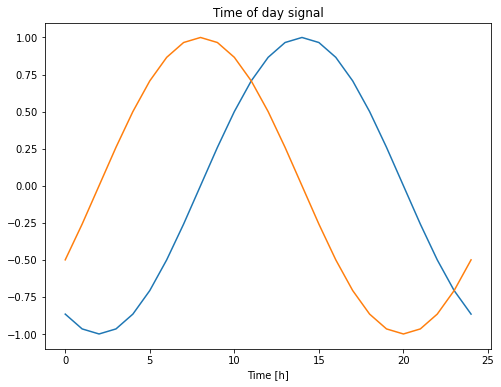

In [44]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In this case we knew ahead of time which frequencies were important, if you didn't know you can find out using an `fft`↓ 

1. Understand why we need to convert to frequencies in the first place ?
2. What does it mean to be "important frequency"  ?
3. How tf.signal.rfft finds important frequency   ?

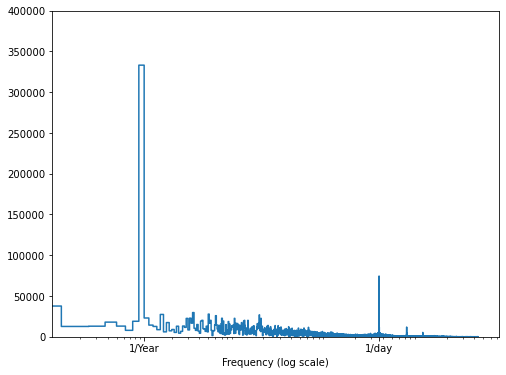

In [45]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [47]:
column_indices = {name:i for i, name in enumerate(df.columns)}

In [49]:
n = len(df)
train_df = df[0:int(n*0.7)].copy()
val_df   = df[int(n*0.7):int(n*0.9)].copy()
test_df  = df[int(n*0.9):].copy()

## Normalize data

Normalization, one way of scaling: $\frac{X-Xmean}{Xstd}$

mean, and std_dev should only be computed using <b> training data </b> so model knows nothing about validation, test sets.

In [53]:
train_df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

      max Wx    max Wy   Day sin       Day cos  Year sin  Year cos  
5  -0.614587 -0.138503 -0.866025 -5.000000e-01  0.003598  0.999994  
11 -0.619848 -0.112645 -0.965926 -2.588190e-01  0.004315  0.999991  
17 -0.614344  0.139576 -1.000000  7.867334e-13  0.005032  0.999987  
23 -0.190000 -0.329090 -0.965926  2.588190e-01  0.005749  0.999983  
29 -0.810044  0.343843 -0.866025  5.000000e-01  0.006465  0.999979

In [55]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df   = (val_df - train_mean) / train_std
test_df  = (test_df - train_mean) / train_std

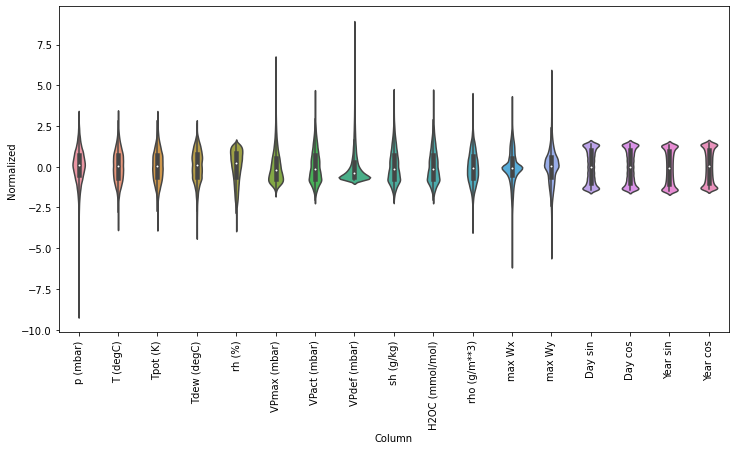

In [66]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [67]:
df_std.head() #melted version

Column  Normalized
0  p (mbar)    0.945308
1  p (mbar)    0.959770
2  p (mbar)    0.986284
3  p (mbar)    1.004362
4  p (mbar)    1.061006

## Data windowing

Main features of input windows:
- length of input and output
- Time offset between them.  --> What is offset???
- Which features are used as inputs, output, or both

In [75]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # label column indicies
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name:i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name:i for i, name in enumerate(train_df.columns)}
        
        # window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        # slice ??
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f"Total window size: {self.total_window_size}",
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [78]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["T (degC)"])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])

In [79]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [80]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [94]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns],
                           axis=-1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

In [95]:
# What is this doing? is it adding a function to WindowGenerator class?
WindowGenerator.split_window = split_window

why [0:7] then [100:107], [200:207] ? what about all rows between them?

In [96]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 17)
Inputs shape: (3, 6, 17)
labels shape: (3, 1, 1)


above, label has one feature(single output) because `WindowGenerator` was initialized with one label_column ["T (degC)"]

In [97]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']